In [46]:
import os
import torch
from data import load_data
from sklearn.model_selection import train_test_split
import numpy as np

In [47]:
from torch import nn

class PlainCNN(nn.Module):
    def __init__(self, n_layer, kernel_size, padding="same", width=3):
        super(PlainCNN, self).__init__()
        self.n_layer = n_layer
        self.kernel_size = kernel_size
        self.padding = padding
        self.width = width

        self.layers = nn.ModuleList()

        for i in range(n_layer):
            if i == 0:
                self.layers.append(nn.Conv2d(3, self.width, kernel_size, padding=padding))
            else:
                self.layers.append(nn.Conv2d(self.width, self.width, kernel_size, padding=padding))
            self.layers.append(nn.ReLU())

        self.layers = nn.Sequential(*self.layers)
        self.fc = nn.Linear(32*32*self.width, 10)

    def forward(self, x):
        x =  self.layers(x)
        x = x.view(-1, 32*32*self.width)
        return self.fc(x)

class MaxCNN(nn.Module):
    def __init__(self, n_layer, kernel_size, padding="same", width=3):
        super(MaxCNN, self).__init__()
        self.n_layer = n_layer
        self.kernel_size = kernel_size
        self.padding = padding
        self.width = width

        self.layers = nn.ModuleList()

        for i in range(n_layer):
            if i == 0:
                self.layers.append(nn.Conv2d(3, self.width, kernel_size, padding=padding))
            else:
                self.layers.append(nn.Conv2d(self.width, self.width, kernel_size, padding=padding))
            self.layers.append(nn.ReLU())

        # for layer in self.layers:
        #     if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
        #         nn.init.normal_(layer.weight, mean=0, std=1)

        # Add Global Max Pooling
        self.layers.append(nn.AdaptiveMaxPool2d(1))
        self.layers = nn.Sequential(*self.layers)

        self.fc = nn.Linear(self.width, 10)

        # nn.init.normal_(self.fc.weight, mean=0, std=1)

    def forward(self, x):
        x = self.layers(x) # (batch, self.width, 32, 32)
        x = x.view(-1, self.width)
        return self.fc(x)

class MeanCNN(nn.Module):
    def __init__(self, n_layer, kernel_size, padding="same", width=3):
        super(MeanCNN, self).__init__()
        self.n_layer = n_layer
        self.kernel_size = kernel_size
        self.padding = padding
        self.width = width

        self.layers = nn.ModuleList()

        for i in range(n_layer):
            if i == 0:
                self.layers.append(nn.Conv2d(3, self.width, kernel_size, padding=padding))
            else:
                self.layers.append(nn.Conv2d(self.width, self.width, kernel_size, padding=padding))
            self.layers.append(nn.ReLU())

        # for layer in self.layers:
        #     if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
        #         nn.init.normal_(layer.weight, mean=0, std=1)

        # Add Global Average Pooling
        self.layers.append(nn.AdaptiveAvgPool2d(1))
        self.layers = nn.Sequential(*self.layers)

        self.fc = nn.Linear(self.width, 10)

        # nn.init.normal_(self.fc.weight, mean=0, std=1)

    def forward(self, x):
        x = self.layers(x) # (batch, self.width, 32, 32)
        # x = x.view(x.size(0), self.width, -1)
        x = x.view(-1, self.width)
        # x = torch.mean(x, dim=1)
        return self.fc(x)

In [48]:
def encode_labels(labels):
    targets = np.ones((len(labels), 10)) * -0.1
    for i, label in enumerate(labels):
        targets[i, label] = 0.9

    return targets

In [49]:
X, Y = load_data()

print(X.shape, Y.shape)

permutation = np.random.permutation(len(X))

n_samples = 2000

X_train = X[permutation][:n_samples]
Y_train = Y[permutation][:n_samples]

X_test = X[permutation][n_samples:]
Y_test = Y[permutation][n_samples:]

# n_samples = 2000
# X = X[:n_samples]
# Y = Y[:n_samples]

# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
# Y_train = encode_labels(Y_train)

(10000, 3, 32, 32) (10000,)


In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [54]:
from sklearn.metrics import accuracy_score
from tqdm import trange

def eval(model, X_test, Y_test):
    predictions = []

    for i in range(0, len(X_test), 32):
        inputs = torch.tensor(X_test[i:i+32], dtype=torch.float32).to(device)
        targets = torch.tensor(Y_test[i:i+32], dtype=torch.long).to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        predictions.extend(predicted.cpu().numpy())

    return accuracy_score(Y_test, predictions)


def train_model(model, X_train, Y_train, X_test, Y_test, batch_size=32, learning_rate=0.1):
    # criterion = nn.MSELoss()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    model = model.to(device)
    previous_acc = 0


    for epoch in range(10):
        for i in range(0, len(X_train), batch_size):
            inputs = torch.tensor(X_train[i:i+batch_size], dtype=torch.float32).to(device)
            targets = torch.tensor(Y_train[i:i+batch_size], dtype=torch.long).to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

        acc_val = eval(model, X_test, Y_test)

        print(f"Epoch {epoch+1}/{10}, Loss: {loss.item()}, Accuracy: {acc_val}")
        # if acc_val > previous_acc:
        #     previous_acc = acc_val
        # else:
        #     break


In [70]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [69]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [58]:
results = {}

In [60]:
width = 128

for n_samples in [200,  250,  500]:

    n_train_samples = int(n_samples * 0.8)

    permutation = np.random.permutation(len(X))
    X_train = X[permutation][:n_train_samples]
    Y_train = Y[permutation][:n_train_samples]
    X_test = X[permutation][n_train_samples:]
    Y_test = Y[permutation][n_train_samples:]


    for depth in [2, 5, 8, 10, 15, 30, 50]:
        model = PlainCNN(n_layer=depth, kernel_size=3, width=width)
        train_model(model, X_train, Y_train, X_test, Y_test, batch_size=64)
        score = eval(model, X_test, Y_test)
        print(score)

        results[("vanilla", depth, width, n_samples)] = score

Epoch 1/10, Loss: 2.2730653285980225, Accuracy: 0.10173913043478261
Epoch 2/10, Loss: 2.242827892303467, Accuracy: 0.15739130434782608
Epoch 3/10, Loss: 2.347280740737915, Accuracy: 0.1375
Epoch 4/10, Loss: 2.1840405464172363, Accuracy: 0.16619565217391305
Epoch 5/10, Loss: 2.1407077312469482, Accuracy: 0.17282608695652174
Epoch 6/10, Loss: 1.8453387022018433, Accuracy: 0.23608695652173914
Epoch 7/10, Loss: 1.551268219947815, Accuracy: 0.21347826086956523
Epoch 8/10, Loss: 0.9302970767021179, Accuracy: 0.21369565217391304
Epoch 9/10, Loss: 0.332619309425354, Accuracy: 0.31369565217391304
Epoch 10/10, Loss: 0.24178868532180786, Accuracy: 0.29695652173913045
0.29695652173913045
Epoch 1/10, Loss: 2.157071590423584, Accuracy: 0.11684782608695653
Epoch 2/10, Loss: 2.303954839706421, Accuracy: 0.09576086956521739
Epoch 3/10, Loss: 2.2471916675567627, Accuracy: 0.1751086956521739
Epoch 4/10, Loss: 2.031339406967163, Accuracy: 0.15097826086956523
Epoch 5/10, Loss: 2.0221941471099854, Accuracy:

In [65]:
width = 128

for n_samples in [200,  250,  500]:

    n_train_samples = int(n_samples * 0.8)

    permutation = np.random.permutation(len(X))
    X_train = X[permutation][:n_train_samples]
    Y_train = Y[permutation][:n_train_samples]
    X_test = X[permutation][n_train_samples:]
    Y_test = Y[permutation][n_train_samples:]


    for depth in [2, 5, 8, 10, 15, 30, 50]:
        model = MaxCNN(n_layer=depth, kernel_size=3, width=width)
        train_model(model, X_train, Y_train, X_test, Y_test, batch_size=64)
        score = eval(model, X_test, Y_test)
        print(score)
        results[("max", depth, width, n_samples)] = score

Epoch 1/10, Loss: 2.3521499633789062, Accuracy: 0.1318089430894309
Epoch 2/10, Loss: 2.234055280685425, Accuracy: 0.09928861788617886
Epoch 3/10, Loss: 2.142108917236328, Accuracy: 0.10904471544715447
Epoch 4/10, Loss: 2.0920655727386475, Accuracy: 0.11788617886178862
Epoch 5/10, Loss: 2.0503973960876465, Accuracy: 0.11890243902439024
Epoch 6/10, Loss: 2.013911247253418, Accuracy: 0.11717479674796748
Epoch 7/10, Loss: 1.9747024774551392, Accuracy: 0.13241869918699187
Epoch 8/10, Loss: 1.934920072555542, Accuracy: 0.13211382113821138
Epoch 9/10, Loss: 1.8960964679718018, Accuracy: 0.13993902439024392
Epoch 10/10, Loss: 1.8537591695785522, Accuracy: 0.15294715447154472
0.15294715447154472
Epoch 1/10, Loss: 2.3213717937469482, Accuracy: 0.10071138211382114
Epoch 2/10, Loss: 2.312958240509033, Accuracy: 0.10071138211382114
Epoch 3/10, Loss: 2.306471824645996, Accuracy: 0.10071138211382114
Epoch 4/10, Loss: 2.3004748821258545, Accuracy: 0.10071138211382114
Epoch 5/10, Loss: 2.29462957382202

In [71]:
width = 128

for n_samples in [200,  250,  500]:

    n_train_samples = int(n_samples * 0.8)

    permutation = np.random.permutation(len(X))
    X_train = X[permutation][:n_train_samples]
    Y_train = Y[permutation][:n_train_samples]
    X_test = X[permutation][n_train_samples:]
    Y_test = Y[permutation][n_train_samples:]


    for depth in [2, 5, 8, 10, 15, 30, 50]:
        model = MeanCNN(n_layer=depth, kernel_size=3, width=width).to(device)
        train_model(model, X_train, Y_train, X_test, Y_test, batch_size=64)
        score = eval(model, X_test, Y_test)
        print(score)
        results[("gap", depth, width, n_samples)] = score

Epoch 1/10, Loss: 2.2988200187683105, Accuracy: 0.12652439024390244
Epoch 2/10, Loss: 2.265625, Accuracy: 0.14278455284552846
Epoch 3/10, Loss: 2.2387278079986572, Accuracy: 0.1415650406504065
Epoch 4/10, Loss: 2.2130610942840576, Accuracy: 0.1445121951219512
Epoch 5/10, Loss: 2.1889843940734863, Accuracy: 0.15050813008130082
Epoch 6/10, Loss: 2.167605400085449, Accuracy: 0.15609756097560976
Epoch 7/10, Loss: 2.1492812633514404, Accuracy: 0.16178861788617885
Epoch 8/10, Loss: 2.133509397506714, Accuracy: 0.16666666666666666
Epoch 9/10, Loss: 2.119821071624756, Accuracy: 0.17388211382113822
Epoch 10/10, Loss: 2.1076653003692627, Accuracy: 0.17845528455284554
0.17845528455284554
Epoch 1/10, Loss: 2.321110725402832, Accuracy: 0.10254065040650406
Epoch 2/10, Loss: 2.3177502155303955, Accuracy: 0.10254065040650406
Epoch 3/10, Loss: 2.3145718574523926, Accuracy: 0.10254065040650406
Epoch 4/10, Loss: 2.3115391731262207, Accuracy: 0.10254065040650406
Epoch 5/10, Loss: 2.308602809906006, Accura

In [72]:
results

{('vanilla', 2, 128, 1000): 0.29695652173913045,
 ('vanilla', 3, 128, 1000): 0.10076086956521739,
 ('vanilla', 5, 128, 1000): 0.1683695652173913,
 ('vanilla', 2, 128, 200): 0.19502032520325202,
 ('vanilla', 3, 128, 200): 0.14715447154471545,
 ('vanilla', 8, 128, 1000): 0.09576086956521739,
 ('vanilla', 10, 128, 1000): 0.09576086956521739,
 ('vanilla', 15, 128, 1000): 0.09576086956521739,
 ('vanilla', 30, 128, 1000): 0.09576086956521739,
 ('vanilla', 50, 128, 1000): 0.09576086956521739,
 ('vanilla', 5, 128, 200): 0.10111788617886179,
 ('vanilla', 8, 128, 200): 0.09735772357723577,
 ('vanilla', 10, 128, 200): 0.09735772357723577,
 ('vanilla', 15, 128, 200): 0.09735772357723577,
 ('vanilla', 30, 128, 200): 0.09735772357723577,
 ('vanilla', 50, 128, 200): 0.09735772357723577,
 ('vanilla', 2, 128, 250): 0.11530612244897959,
 ('vanilla', 5, 128, 250): 0.10153061224489796,
 ('vanilla', 8, 128, 250): 0.09295918367346939,
 ('vanilla', 10, 128, 250): 0.09295918367346939,
 ('vanilla', 15, 128, 25

In [ ]:
results = {
     ('vanilla', 5, 128, 200): 0.10111788617886179,
 ('vanilla', 8, 128, 200): 0.09735772357723577,
 ('vanilla', 10, 128, 200): 0.09735772357723577,
 ('vanilla', 15, 128, 200): 0.09735772357723577,
 ('vanilla', 30, 128, 200): 0.09735772357723577,
 ('vanilla', 50, 128, 200): 0.09735772357723577,
 ('vanilla', 2, 128, 250): 0.11530612244897959,
 ('vanilla', 5, 128, 250): 0.10153061224489796,
 ('vanilla', 8, 128, 250): 0.09295918367346939,
 ('vanilla', 10, 128, 250): 0.09295918367346939,
 ('vanilla', 15, 128, 250): 0.09295918367346939,
 ('vanilla', 30, 128, 250): 0.09295918367346939,
 ('vanilla', 50, 128, 250): 0.09295918367346939,
 ('vanilla', 2, 128, 500): 0.1184375,
 ('vanilla', 5, 128, 500): 0.10260416666666666,
 ('vanilla', 8, 128, 500): 0.10260416666666666,
 ('vanilla', 10, 128, 500): 0.10260416666666666,
 ('vanilla', 15, 128, 500): 0.10260416666666666,
 ('vanilla', 30, 128, 500): 0.10260416666666666,
 ('vanilla', 50, 128, 500): 0.10260416666666666,
    ('gap', 2, 128): 0.19947916666666668,
 ('gap', 5, 128): 0.13322916666666668,
 ('gap', 8, 128): 0.09958333333333333,
 ('gap', 10, 128): 0.09958333333333333,
 ('gap', 15, 128): 0.09958333333333333,
 ('gap', 30, 128): 0.09958333333333333,
 ('gap', 50, 128): 0.09958333333333333,
 ('gap', 2, 128, 200): 0.17845528455284554,
 ('gap', 5, 128, 200): 0.0975609756097561,
 ('gap', 8, 128, 200): 0.10284552845528455,
 ('gap', 10, 128, 200): 0.0975609756097561,
 ('gap', 15, 128, 200): 0.0975609756097561,
 ('gap', 30, 128, 200): 0.0975609756097561,
 ('gap', 50, 128, 200): 0.0975609756097561,
 ('gap', 2, 128, 250): 0.17122448979591837,
 ('gap', 5, 128, 250): 0.09959183673469388,
 ('gap', 8, 128, 250): 0.09959183673469388,
 ('gap', 10, 128, 250): 0.09959183673469388,
 ('gap', 15, 128, 250): 0.09959183673469388,
 ('gap', 30, 128, 250): 0.09959183673469388,
 ('gap', 50, 128, 250): 0.09959183673469388,
 ('gap', 2, 128, 500): 0.19135416666666666,
 ('gap', 5, 128, 500): 0.12270833333333334,
 ('gap', 8, 128, 500): 0.10260416666666666,
 ('gap', 10, 128, 500): 0.10260416666666666,
 ('gap', 15, 128, 500): 0.09364583333333333,
 ('gap', 30, 128, 500): 0.10260416666666666,
 ('gap', 50, 128, 500): 0.10260416666666666}

In [73]:
# results to pandas
import pandas as pd

data = {
    "model": [],
    "depth": [],
    "width": [],
    "accuracy": [],
    "n_samples": []
}

for key, value in results.items():
    model, depth, width, n_samples = key
    data["model"].append(model)
    data["depth"].append(depth)
    data["width"].append(width)
    data["accuracy"].append(value)
    data["n_samples"].append(n_samples)

df = pd.DataFrame(data)
df

ValueError: not enough values to unpack (expected 4, got 3)

Text(0, 0.5, 'Number of Samples')

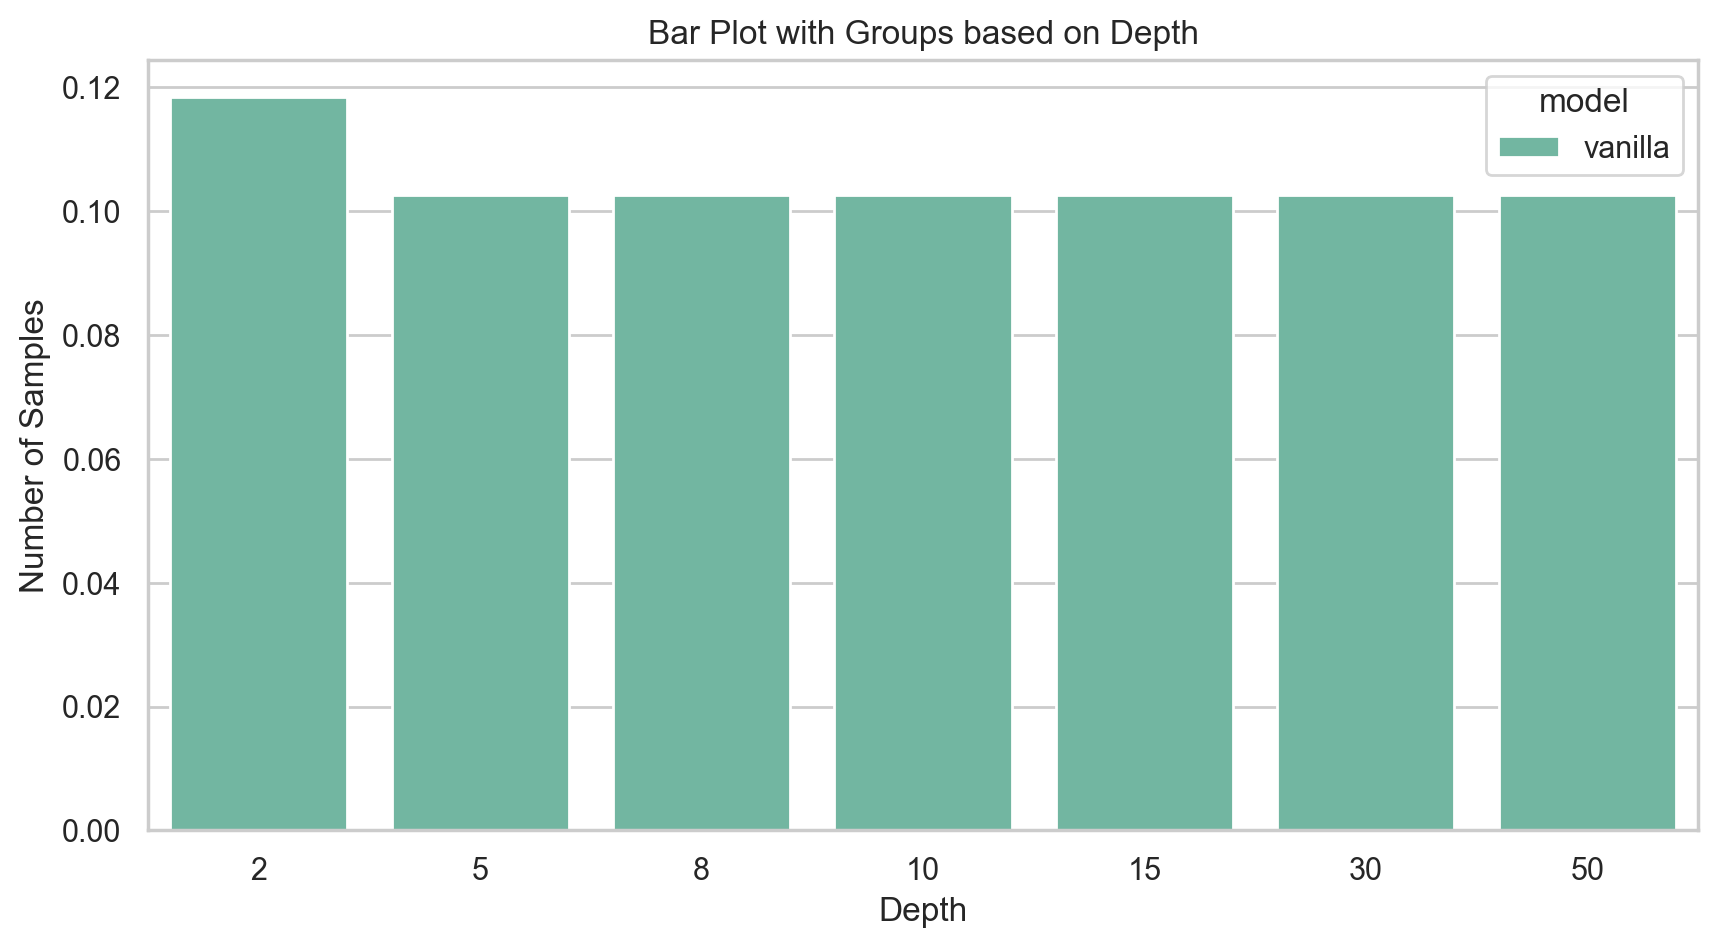

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

plt.figure(figsize=(10, 5), dpi=200)
sns.barplot(x='depth', y='accuracy', hue='model', data=df[df["n_samples"] == 500], palette="Set2", ci=None)

# Add title and labels
plt.title('Bar Plot with Groups based on Depth')
plt.xlabel('Depth')
plt.ylabel('Number of Samples')

In [2]:
# results2 =  {
#  ('gap', 2, 128): 0.238125,
#  ('gap', 3, 128): 0.23225,
#  ('gap', 5, 128): 0.225,
#  ('vanilla', 2, 128): 0.328375,
#  ('vanilla', 3, 128): 0.305,
#  ('vanilla', 5, 128): 0.240625,
#  ('max', 2, 128): 0.384375,
#  ('max', 3, 128): 0.320875,
#  ('max', 5, 128): 0.223,
#  ('max', 10, 128): 0.101
# }

In [21]:
bars = {
    2: [results[("vanilla", 2, 128)], results[("max", 2, 128)], results[("gap", 2, 128)]],
    3: [results[("vanilla", 3, 128)], results[("max", 3, 128)], results[("gap", 3, 128)]],
    5: [results[("vanilla", 5, 128)], results[("max", 5, 128)], results[("gap", 5, 128)]],
}

bars = {
    "vanilla": [results[("vanilla", 2, 128)], results[("vanilla", 3, 128)], results[("vanilla", 5, 128)]],
    "max": [results[("max", 2, 128)], results[("max", 3, 128)], results[("max", 5, 128)]],
    "gap": [results[("gap", 2, 128)], results[("gap", 3, 128)], results[("gap", 5, 128)]],
}

C:\Users\Antoine\AppData\Local\Temp\ipykernel_11748\3577955719.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab10', 3)
C:\Users\Antoine\AppData\Local\Temp\ipykernel_11748\3577955719.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


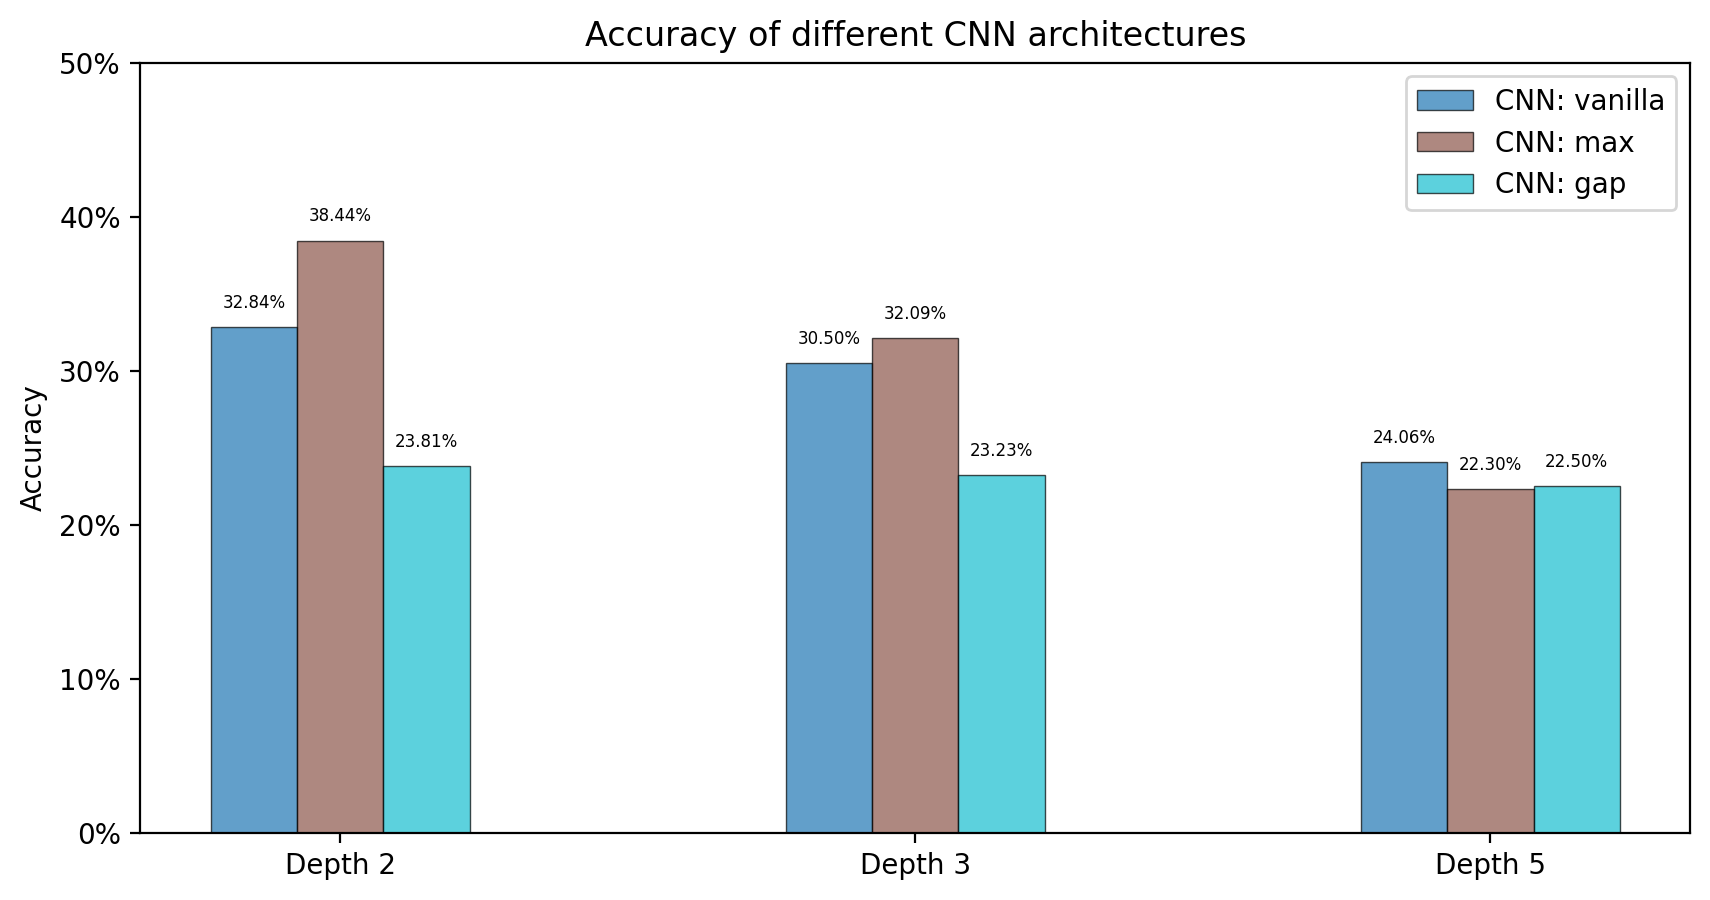

In [35]:
import matplotlib.pyplot as plt

colormap = plt.cm.get_cmap('tab10', 3)

# Plot bar chart
plt.figure(figsize=(10, 5), dpi=200)

x = np.arange(3)
multiplier = 0
width = 0.15
for i, (depth, scores) in enumerate(bars.items()):
    offset = width * multiplier
    rects = plt.bar(x + offset, scores, width, label=f"CNN: {depth}", color=colormap(i), align='center', alpha=0.7, edgecolor='black', linewidth=0.5, capsize=5)
    # Add scores on top of the bars
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2.0, height + 0.01, f"{height:.2%}", ha='center', va='bottom', fontsize=6)
    multiplier += 1

plt.xticks(x + width, ["Depth 2", "Depth 3", "Depth 5"])
# Set accuracy to percentage from 0% to 100% string
plt.ylim(0, 0.5)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.title("Accuracy of different CNN architectures")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [71]:
list(results.values())[:3], list(results.values())[3:6], list(results.values())[6:9]

([0.238125, 0.23225, 0.225],
 [0.328375, 0.305, 0.240625],
 [0.384375, 0.320875, 0.223])

In [36]:
import pandas as pd

In [38]:
df = pd.read_csv("results.csv")
df

,depth,n_samples,accuracy,type
0,2,1000,0.40,gap
1,2,1000,0.40,gap
2,2,1000,0.08,max
3,2,1000,0.08,max
4,2,1000,0.33,vanilla
...,...,...,...,...
153,50,500,0.33,gap
154,50,500,0.27,max
155,50,500,0.27,max
156,50,500,0.28,vanilla


In [45]:
df["n_samples"].unique()

array([1000,  200,  250,  500], dtype=int64)

In [43]:
data = {
    'depth': [2, 3, 5, 2, 3, 5, 2, 3, 5],
    'accuracy': list(results.values())[:-1],
    'n_samples': [2000*0.8]*9,
    'type': ["vanilla"]*3 + ["max"]*3 + ["gap"]*3
}
print(data)

df2 = pd.DataFrame(data)
df2

{'depth': [2, 3, 5, 2, 3, 5, 2, 3, 5], 'accuracy': [0.238125, 0.23225, 0.225, 0.328375, 0.305, 0.240625, 0.384375, 0.320875, 0.223], 'n_samples': [1600.0, 1600.0, 1600.0, 1600.0, 1600.0, 1600.0, 1600.0, 1600.0, 1600.0], 'type': ['vanilla', 'vanilla', 'vanilla', 'max', 'max', 'max', 'gap', 'gap', 'gap']}


,depth,accuracy,n_samples,type
0,2,0.238125,1600.0,vanilla
1,3,0.232250,1600.0,vanilla
2,5,0.225000,1600.0,vanilla
3,2,0.328375,1600.0,max
4,3,0.305000,1600.0,max
5,5,0.240625,1600.0,max
6,2,0.384375,1600.0,gap
7,3,0.320875,1600.0,gap
8,5,0.223000,1600.0,gap


In [44]:
df_concat = pd.concat([df, df2])
df_concat

,depth,n_samples,accuracy,type
0,2,1000.0,0.400000,gap
1,2,1000.0,0.400000,gap
2,2,1000.0,0.080000,max
3,2,1000.0,0.080000,max
4,2,1000.0,0.330000,vanilla
...,...,...,...,...
4,3,1600.0,0.305000,max
5,5,1600.0,0.240625,max
6,2,1600.0,0.384375,gap
7,3,1600.0,0.320875,gap


In [ ]:
results =  {
 ('gap', 2, 128): 0.238125,
 ('gap', 3, 128): 0.23225,
 ('gap', 5, 128): 0.225,
 ('vanilla', 2, 128): 0.328375,
 ('vanilla', 3, 128): 0.305,
 ('vanilla', 5, 128): 0.240625,
 ('max', 2, 128): 0.384375,
 ('max', 3, 128): 0.320875,
 ('max', 5, 128): 0.223,
 ('max', 10, 128): 0.101
}

data = {'depth': [1, 1, 2, 2, 3, 3],
        'n_samples': [10, 15, 12, 18, 8, 10],
        'accuracy': [0.8, 0.9, 0.7, 0.85, 0.75, 0.82],
        'type': ['A', 'B', 'A', 'B', 'A', 'B']}